# Train AlexNet with Tiny ImageNet-200

We are going to train the [AlexNet](https://arxiv.org/abs/1404.5997) model to work with the [Tiny ImageNet-200](https://tiny-imagenet.herokuapp.com/), a subset of ImageNet with 200 classes.

But we are not going to train it from the scratch, we are going to use the pre-trained model from [torchvision](http://pytorch.org/docs/master/torchvision/models.html), stripping the last layer and replacing it by a fresh layer that outputs 200 units instead of the original 1000 units for ImageNet. The last layer is the one we are going to train.

In [1]:
%matplotlib inline

from __future__ import print_function

import json
import os

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Variable

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models

import matplotlib.pyplot as plt
from itertools import islice

Some constants for the notebook.

In [2]:
directory = "/datasets/tiny-imagenet-200/"
num_classes = 200

## Loading and pre-processing

First we load and pre-process the data according to the pre-trained model [documentation](http://pytorch.org/docs/master/torchvision/models.html), applying transformations using [this example](https://github.com/pytorch/examples/blob/42e5b996718797e45c46a25c55b031e6768f8440/imagenet/main.py#L89-L113).

For training data, we resize and crop randomly to get images of 224x224, flip horizontally some of the images, transform them to a tensor and finally normalize them to have values between 0 and 1. The magic normalization parameters come from the example.

For the validation data we use less corrupted images, only resizing them and cropping them in the center and then appliying the rest.

In [23]:
# modify this depending on memory constraints
batch_size = 64

# the magic normalization parameters come from the example
transform_mean = np.array([ 0.485, 0.456, 0.406 ])
transform_std = np.array([ 0.229, 0.224, 0.225 ])

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean = transform_mean, std = transform_std),
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean = transform_mean, std = transform_std),
])

traindir = os.path.join(directory, "train")
# be careful with this set, the labels are not defined using the directory structure
valdir = os.path.join(directory, "val")

train = datasets.ImageFolder(traindir, train_transform)
val = datasets.ImageFolder(valdir, val_transform)

train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=True)

assert num_classes == len(train_loader.dataset.classes)

## Label madness

[WordNet](https://wordnet.princeton.edu/) is a large lexical database of English. ImageNet uses a subset of this database as labels for the images, and the Tiny ImageNet-200 uses an even smaller subset. The Tiny ImageNet-200 comes with a map between WordNet ids and WordNet definitions. 

In [7]:
small_labels = {}
with open(os.path.join(directory, "words.txt"), "r") as dictionary_file:
    line = dictionary_file.readline()
    while line:
        label_id, label = line.strip().split("\t")
        small_labels[label_id] = label
        line = dictionary_file.readline()

In [8]:
list(small_labels.items())[:5]

[('n00001740', 'entity'),
 ('n00001930', 'physical entity'),
 ('n00002137', 'abstraction, abstract entity'),
 ('n00002452', 'thing'),
 ('n00002684', 'object, physical object')]

The train subdirectory of Tiny ImageNet-200 has a collection of subdirectories, named using to the WordNet ids to label the images that they contain. The torchvision data loader uses the names of the subdirectories as labels, but replaces them with numeric indices when iterating the batches.

In [9]:
os.listdir(traindir)[:5]

['.DS_Store', 'n01443537', 'n01629819', 'n01641577', 'n01644900']

In [10]:
labels = {}
label_ids = {}
for label_index, label_id in enumerate(train_loader.dataset.classes):
    label = small_labels[label_id]
    labels[label_index] = label
    label_ids[label_id] = label_index

In [11]:
list(labels.items())[:5]

[(0, 'goldfish, Carassius auratus'),
 (1, 'European fire salamander, Salamandra salamandra'),
 (2, 'bullfrog, Rana catesbeiana'),
 (3, 'tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui'),
 (4, 'American alligator, Alligator mississipiensis')]

In [12]:
list(label_ids.items())[:5]

[('n01443537', 0),
 ('n01629819', 1),
 ('n01641577', 2),
 ('n01644900', 3),
 ('n01698640', 4)]

Another problem is that the validation directory only has one subdirectory called `images`. The labels for every image inside this subdirectory are defined in a file called `val_annotations.txt`.

In [13]:
val_label_map = {}
with open(os.path.join(directory, "val/val_annotations.txt"), "r") as val_label_file:
    line = val_label_file.readline()
    while line:
        file_name, label_id, _, _, _, _ = line.strip().split("\t")
        val_label_map[file_name] = label_id
        line = val_label_file.readline()

In [14]:
list(val_label_map.items())[:5]

[('val_0.JPEG', 'n03444034'),
 ('val_1.JPEG', 'n04067472'),
 ('val_2.JPEG', 'n04070727'),
 ('val_3.JPEG', 'n02808440'),
 ('val_4.JPEG', 'n02808440')]

Finally we update the Tiny ImageNet-200 validation set labels:

In [15]:
val_loader.dataset.imgs[:5]

[('datasets/tiny-imagenet-200/val/images/val_0.JPEG', 0),
 ('datasets/tiny-imagenet-200/val/images/val_1.JPEG', 0),
 ('datasets/tiny-imagenet-200/val/images/val_10.JPEG', 0),
 ('datasets/tiny-imagenet-200/val/images/val_100.JPEG', 0),
 ('datasets/tiny-imagenet-200/val/images/val_1000.JPEG', 0)]

In [16]:
for i in range(len(val_loader.dataset.imgs)):
    file_path = val_loader.dataset.imgs[i][0]
    
    file_name = os.path.basename(file_path)
    label_id = val_label_map[file_name]
    
    val_loader.dataset.imgs[i] = (file_path, label_ids[label_id])

In [17]:
val_loader.dataset.imgs[:5]

[('datasets/tiny-imagenet-200/val/images/val_0.JPEG', 107),
 ('datasets/tiny-imagenet-200/val/images/val_1.JPEG', 139),
 ('datasets/tiny-imagenet-200/val/images/val_10.JPEG', 158),
 ('datasets/tiny-imagenet-200/val/images/val_100.JPEG', 90),
 ('datasets/tiny-imagenet-200/val/images/val_1000.JPEG', 138)]

## Training

Xavier weight initialization for the extra layer.

In [18]:
def initialize_weights(m):
    weight_shape = list(m.weight.data.size())
    fan_in = weight_shape[1]
    fan_out = weight_shape[0]
    w_bound = np.sqrt(6. / (fan_in + fan_out))
    m.weight.data.uniform_(-w_bound, w_bound)
    m.bias.data.fill_(0)

Load the pre-trained error, get the weights and remove the last lawer parameters.

Create an empty model with the desired last layer size, copy the parameters and initialize the rest.

Note that only the new parameters will be used for training.

In [19]:
pre_trained_model = models.alexnet(pretrained=True)
state_dict = pre_trained_model.state_dict()
state_dict.pop("classifier.6.weight")
state_dict.pop("classifier.6.bias")
model = models.alexnet(num_classes=num_classes)
model.load_state_dict(state_dict, strict=False)

# parameters = model.classifier[6].parameters()
parameters = list(model.classifier[6].parameters())
initialize_weights(model.classifier[6])

model = model.cpu()
# model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(parameters, lr=0.001, momentum=0.9)

Show the percentage of error in the top-k most probable classes.

In [20]:
def top_k_error(top_k, total):
    return 100.0 - top_k / total * 100.0

Run one epoch, either with training or evaluation.

In [21]:
import time
def run_epoch(loader, train=True, log_every=100, max_batch=0):
    running_loss = 0.0
    running_top_1 = 0.0
    running_top_5 = 0.0
    running_total = 0.0
    
    epoch_top_1 = 0.0
    epoch_top_5 = 0.0
    epoch_total = 0.0
    
    model.train(mode=train)
    
    batch_start = time.time()
    batch_load = 0.0
    batch_compute = 0.0

    for batch_number, (batch_inputs, batch_labels) in enumerate(loader):
        batch_loaded = time.time()
        batch_load += batch_loaded - batch_start
        
        batch_inputs, batch_labels = Variable(batch_inputs.cpu()), Variable(batch_labels.cpu())
#         batch_inputs, batch_labels = Variable(batch_inputs.cuda()), Variable(batch_labels.cuda())

        if train:
            optimizer.zero_grad()

        batch_logits = model(batch_inputs)
        
        if train:
            batch_loss = criterion(batch_logits, batch_labels)
            batch_loss.backward()
        
            optimizer.step()
            
            running_loss += batch_loss.data.cpu().item()
            
        batch_end = time.time()
        batch_compute += batch_end - batch_loaded
        
        batch_labels = batch_labels.data.cpu().numpy()
        batch_predictions = batch_logits.topk(5)[1].data.cpu().numpy()
    
        for i in range(len(batch_labels)):
            if batch_labels[i] == batch_predictions[i, 0]:
                running_top_1 += 1
                running_top_5 += 1
                epoch_top_1 += 1
                epoch_top_5 += 1
            else:
                for j in range(1, 5):
                    if batch_labels[i] == batch_predictions[i, j]:
                        running_top_5 += 1
                        epoch_top_5 += 1
                        break
        
        running_total += len(batch_labels)
        epoch_total += len(batch_labels)

        if batch_number % log_every == log_every - 1:
            if train:
                print("[Batch {:5d}] Loss: {:.3f} Top-1 Error: {:.3f} Top-5 Error: {:.3f}, Load time: {:.3f} ms, Compute time: {:.3f} ms".format(
                    batch_number + 1,
                    running_loss / log_every,
                    top_k_error(running_top_1, running_total),
                    top_k_error(running_top_5, running_total),
                    batch_load * 1000 / log_every,
                    batch_compute * 1000 / log_every,
                ))
            
            running_loss = 0.0
            running_top_1 = 0.0
            running_top_5 = 0.0
            running_total = 0.0
            batch_load = 0.0
            batch_compute = 0.0
            
        if max_batch > 0 and batch_number >= max_batch - 1:
            break
            
    return top_k_error(epoch_top_1, epoch_total), top_k_error(epoch_top_5, epoch_total)

In [24]:
num_epochs = 1 # modify this to run different number of epochs

for epoch_number in range(num_epochs):

    train_top_1_error, train_top_5_error = run_epoch(train_loader, train=True, log_every=1, max_batch=10)
    print("[Epoch {:3d}] Training Top-1 Error: {:.3f} Top-5 Error: {:.3f}".format(
        epoch_number + 1, train_top_1_error, train_top_5_error))

    val_top_1_error, val_top_5_error = run_epoch(val_loader, train=False, max_batch=10)
    print("[Epoch {:3d}] Validation Top-1 Error: {:.3f} Top-5 Error: {:.3f}".format(
        epoch_number + 1, val_top_1_error, val_top_5_error))

print("Finished Training")

ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_105/3670274374.py", line 5, in <module>
    train_top_1_error, train_top_5_error = run_epoch(train_loader, train=True, log_every=1, max_batch=10)
  File "/tmp/ipykernel_105/1942339389.py", line 18, in run_epoch
    for batch_number, (batch_inputs, batch_labels) in enumerate(loader):
  File "/opt/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 521, in __next__
    data = self._next_data()
  File "/opt/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1203, in _next_data
    return self._process_data(data)
  File "/opt/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1229, in _process_data
    data.reraise()
  File "/opt/conda/lib/python3.9/site-packages/torch/_utils.py", line 434, in reraise
    raise exce

TypeError: object of type 'NoneType' has no len()

ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 

## Plot some samples

To be sure that we did not mess up with the labels and see how the model works.

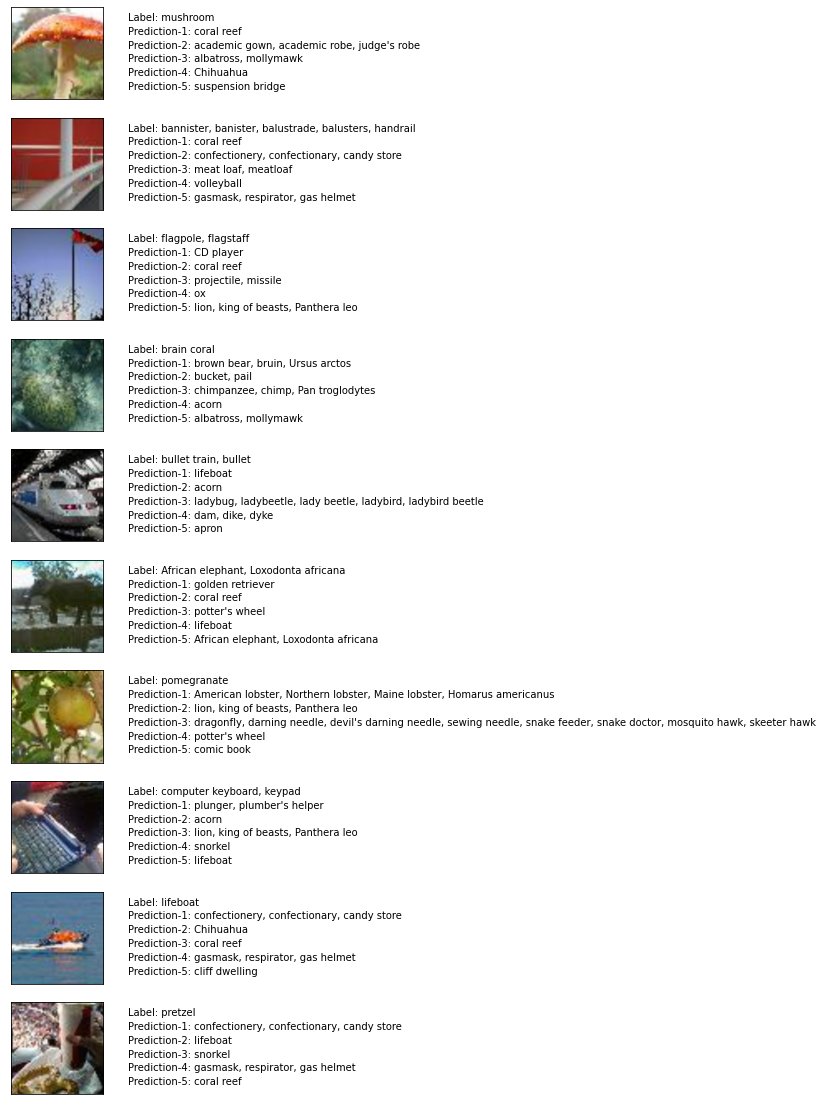

In [22]:
model.train(mode=False)

num_images = 10 # modify the number of images shown

batch_inputs, batch_labels = next(iter(val_loader))
with torch.no_grad():
    batch_inputs = Variable(batch_inputs.cpu())
# batch_inputs = Variable(batch_inputs.cuda(), volatile=True)

batch_logits = model(batch_inputs)

batch_labels = batch_labels.numpy()
batch_predictions = batch_logits.topk(5)[1].data.cpu().numpy()

cell_number = 1

plt.figure(figsize=(4, num_images * 2))

for image_number in range(num_images):
    image = np.copy(batch_inputs.data[image_number].cpu().numpy())
    image = np.transpose(image, (1, 2, 0))
    for channel in range(3):
        image[:, :, channel] = image[:, :, channel] * transform_std[channel] + transform_mean[channel]

    label = labels[batch_labels[image_number]]

    plt.subplot(num_images, 2, cell_number)

    ax = plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    
    cell_number += 1

    plt.subplot(num_images, 2, cell_number)
    plt.axis("off")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.text(0, 0.85, "Label: {}".format(label))
    for prediction_number in range(5):
        plt.text(0, 0.85 - 0.15 * (prediction_number + 1), "Prediction-{:d}: {}".format(
            prediction_number + 1, labels[batch_predictions[image_number, prediction_number]]))
    
    cell_number += 1

plt.show()